<a href="https://colab.research.google.com/github/Sanjeev22A/SudokuSolver/blob/main/PROTOTYPE/SudokoImageSolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
image_dir_path="/content/Sudoku_Dataset"
image1="/sudoku1.png"
image2="/sudoku2.jpg"

In [ ]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
def preprocess(image_path,height=800):
  image=cv2.imread(image_path)
  ##Resizing the image for smaller pixel sizes
  image=imutils.resize(image,height=height)
  ## Step 1: Converting to gray scale
  gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  ## Step 1.1 : Histogram equalization to normalize contrast across the whole image
  gray=cv2.equalizeHist(gray)
  plt.subplot(1,4,1); plt.imshow(gray, cmap='gray'); plt.title("Gray")
  ## Step 2: Gaussing Blurring for noise reduction
  blurred = cv2.GaussianBlur(gray,(7,7),3,cv2.BORDER_REFLECT_101)
  plt.subplot(1,4,2); plt.imshow(blurred, cmap='gray'); plt.title("Blurred")
  ## Step 3: Adaptive Thresholding
  ## https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
  thresh= cv2.adaptiveThreshold(
      blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3
  )
  plt.subplot(1,4,3); plt.imshow(thresh, cmap='gray'); plt.title("Threshold")
  ## Step 4: Invert to make grid lines white
  thresh=cv2.bitwise_not(thresh)

  ## Step 5: Morphological op
  kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
  processed=cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel)

  plt.subplot(1,4,4); plt.imshow(processed, cmap='gray'); plt.title("Edges")
  return image,processed

/content/Sudoku_Dataset/sudoku1.png


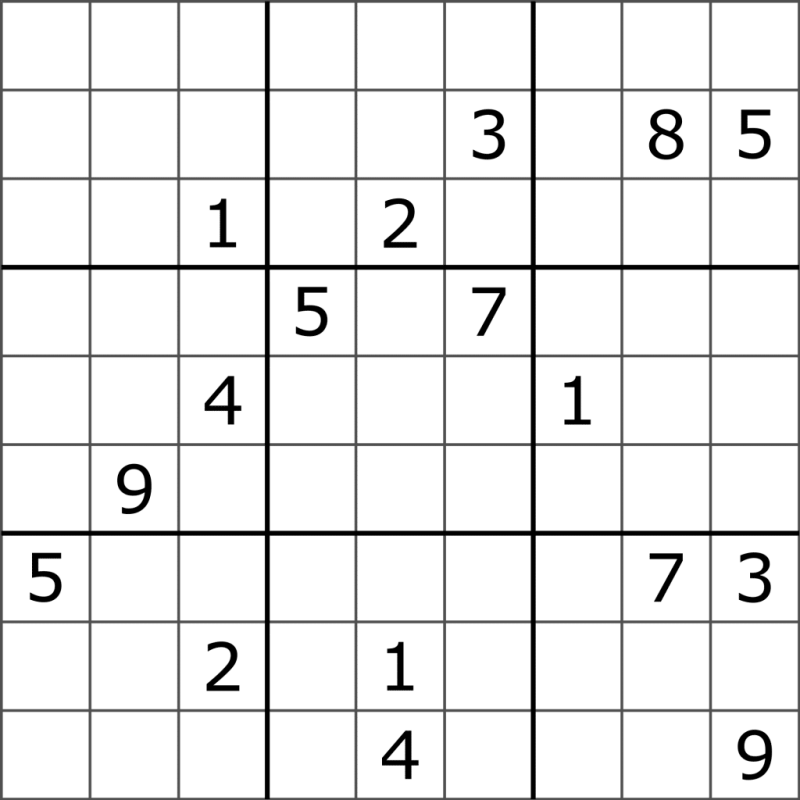

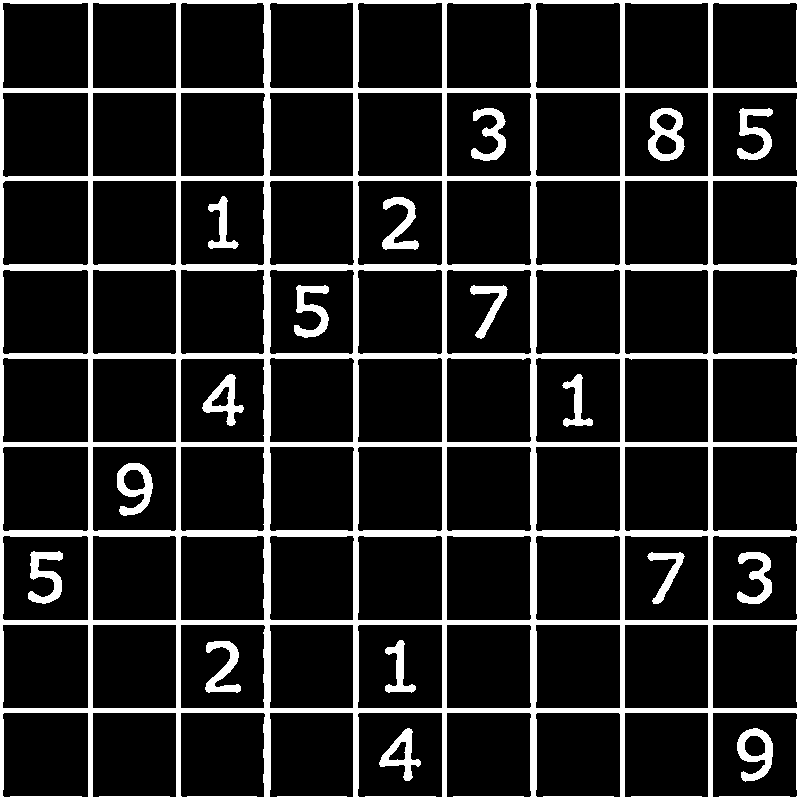

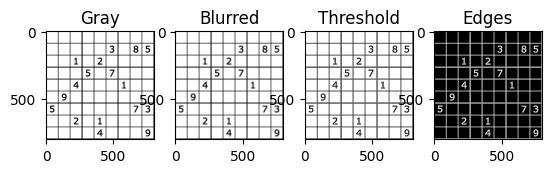

In [ ]:
from google.colab.patches import cv2_imshow
image_path=image_dir_path+image1
print(image_path)
# Check if the file exists
if not os.path.exists(image_path):
    print("❌ Error: Image file not found at", image_path)
original,processed=preprocess(image_path)
cv2_imshow(original)
cv2_imshow(processed)

/content/Sudoku_Dataset/sudoku2.jpg


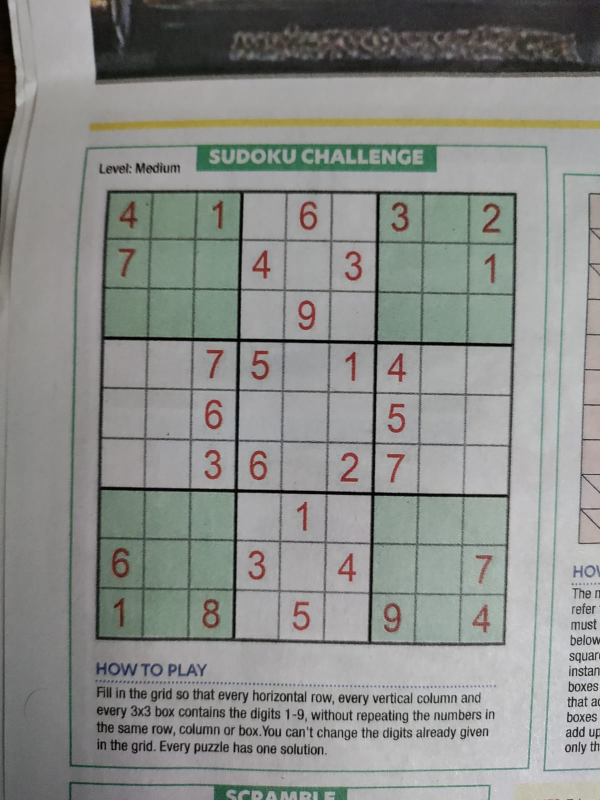

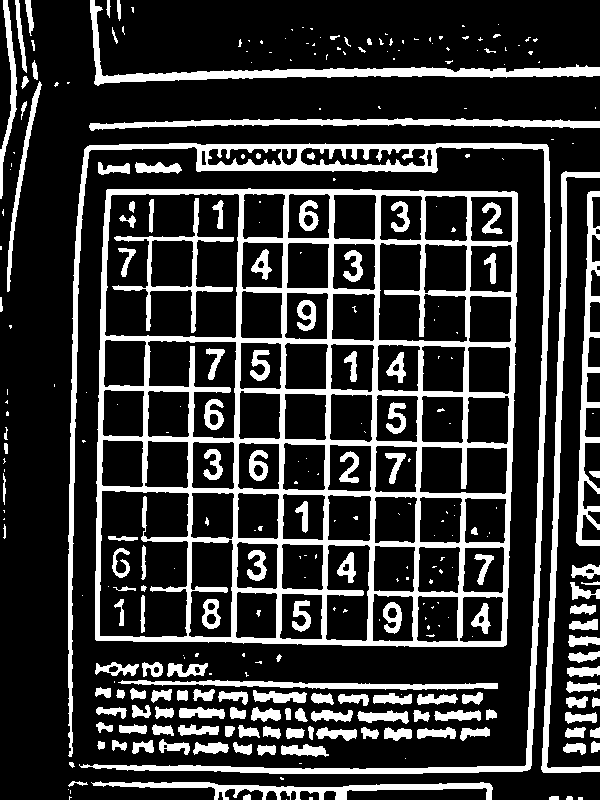

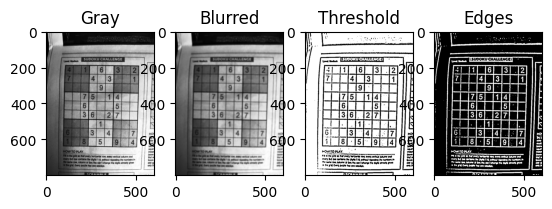

In [ ]:
from google.colab.patches import cv2_imshow
image_path=image_dir_path+image2
print(image_path)
# Check if the file exists
if not os.path.exists(image_path):
    print("❌ Error: Image file not found at", image_path)
original,processed=preprocess(image_path)
cv2_imshow(original)
cv2_imshow(processed)

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]   # top-left has smallest sum
    rect[2] = pts[np.argmax(s)]   # bottom-right has largest sum

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right has smallest difference
    rect[3] = pts[np.argmax(diff)]  # bottom-left has largest difference
    return rect


In [ ]:
def detect_sudoku_grid(processed,original_image):
    contours = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    sudoku_contour = None
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.03 * peri, True)
        if len(approx) == 4:
            sudoku_contour = approx
            break

    if sudoku_contour is None:
        print("❌ Sudoku grid not found.")
        return None, None

    # Order corners
    sudoku_contour = sudoku_contour.reshape(4, 2)
    rect = order_points(sudoku_contour)

    # Draw contour for visualization
    debug_img = original_image.copy()
    cv2.drawContours(debug_img, [sudoku_contour.astype(int)], -1, (0, 255, 0), 3)

    return rect, debug_img

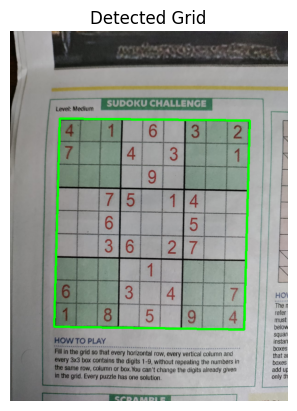

In [ ]:
rect, debug = detect_sudoku_grid(processed, original)
plt.imshow(cv2.cvtColor(debug, cv2.COLOR_BGR2RGB))
plt.title("Detected Grid")
plt.axis('off')
plt.show()


In [ ]:
def wrap_sudoku(order_points,original_image):
  output_size=450
  dst = np.array([
        [0, 0],
        [output_size - 1, 0],
        [output_size - 1, output_size - 1],
        [0, output_size - 1]
    ], dtype="float32")
  M=cv2.getPerspectiveTransform(rect,dst)
  warped=cv2.warpPerspective(original_image,M,(output_size,output_size))
  return warped

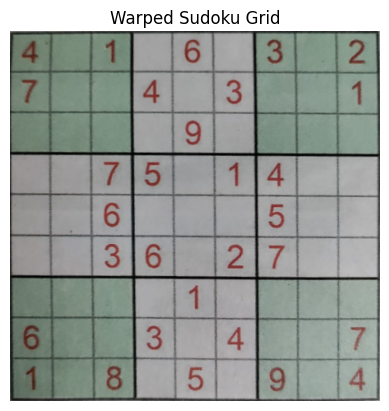

In [ ]:
warped_image=wrap_sudoku(rect,original)
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.title("Warped Sudoku Grid")
plt.axis("off")
plt.show()

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # ✅ Required for Colab display

def preprocess_wrapped_sudoku(warped, show_steps=False):
    """
    Preprocess a warped Sudoku image for digit extraction.

    Steps:
    1. Convert to grayscale
    2. Histogram equalization
    3. Gaussian blur
    4. Adaptive thresholding (binary inverse)

    Parameters:
        warped (np.ndarray): Warped Sudoku image (top-down view)
        show_steps (bool): If True, displays intermediate steps

    Returns:
        thresh (np.ndarray): Final preprocessed (binary) image
        steps (dict): Dictionary of intermediate results
    """

    steps = {}

    # 1️⃣ Grayscale conversion
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY) if len(warped.shape) == 3 else warped
    steps["gray"] = gray

    # 2️⃣ Histogram equalization for better contrast
    gray_eq = cv2.equalizeHist(gray)
    steps["equalized"] = gray_eq

    # 3️⃣ Gaussian blur to reduce small noise
    blurred = cv2.GaussianBlur(gray,(7,7),3,cv2.BORDER_REFLECT_101)
    steps["blurred"] = blurred

    # 4️⃣ Adaptive threshold (invert so digits are white)
    thresh = cv2.adaptiveThreshold(
      blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,1
    )
    steps["thresh"] = thresh

    # Optional visualization
    if show_steps:
        titles = ["Gray", "Equalized", "Blurred", "Thresholded"]
        images = [steps[k] for k in ["gray", "equalized", "blurred", "thresh"]]
        for title, img in zip(titles, images):
            print(f"📷 {title}")
            cv2_imshow(img)  # ✅ Show image in Colab

    return thresh, steps


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # ✅ required in Colab

def split_into_cells(preprocessed_img, grid_size=9, visualize=False):
    """
    Splits a preprocessed Sudoku image into 81 individual cell images (9x9 grid).

    Parameters:
        preprocessed_img (np.ndarray): Binary (thresholded) top-down Sudoku image
        grid_size (int): Number of rows and columns (default 9)
        visualize (bool): If True, shows each cell in a grid visualization

    Returns:
        cells (list): List of 81 cell images (each as np.ndarray)
    """

    h, w = preprocessed_img.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size

    cells = []

    for i in range(grid_size):
        for j in range(grid_size):
            # Crop each cell
            y1, y2 = i * cell_h, (i + 1) * cell_h
            x1, x2 = j * cell_w, (j + 1) * cell_w

            cell = preprocessed_img[y1:y2, x1:x2]

            # Optional cleanup (remove extra border pixels)
            margin = 2
            cell = cell[margin:-margin, margin:-margin] if cell.shape[0] > 4 and cell.shape[1] > 4 else cell

            cells.append(cell)

    # ✅ Visualization grid (only if requested)
    if visualize:
        cell_grid = np.zeros((h, w), dtype=np.uint8)
        idx = 0
        for i in range(grid_size):
            for j in range(grid_size):
                y1, y2 = i * cell_h, (i + 1) * cell_h
                x1, x2 = j * cell_w, (j + 1) * cell_w
                cell_resized = cv2.resize(cells[idx], (cell_w, cell_h))
                cell_grid[y1:y2, x1:x2] = cell_resized
                idx += 1
        cv2_imshow(cell_grid)  # ✅ works in Colab

    return cells


📷 Gray


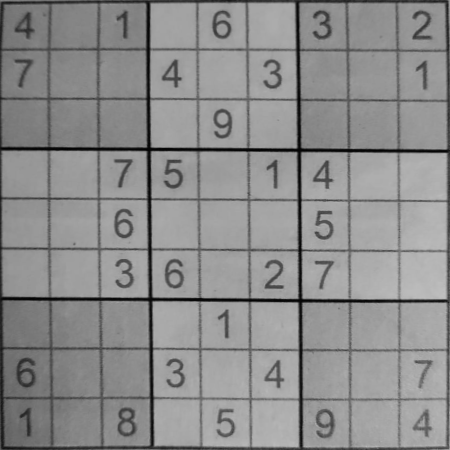

📷 Equalized


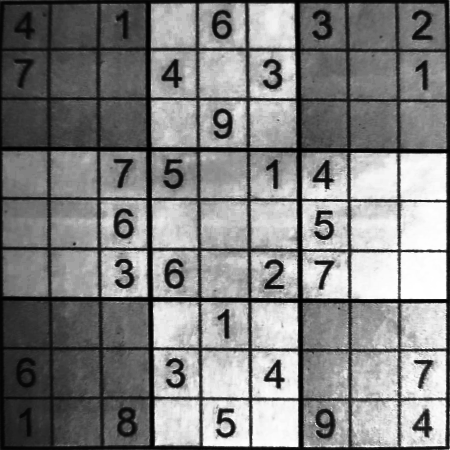

📷 Blurred


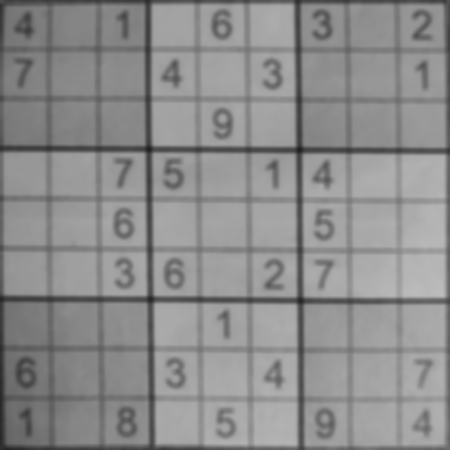

📷 Thresholded


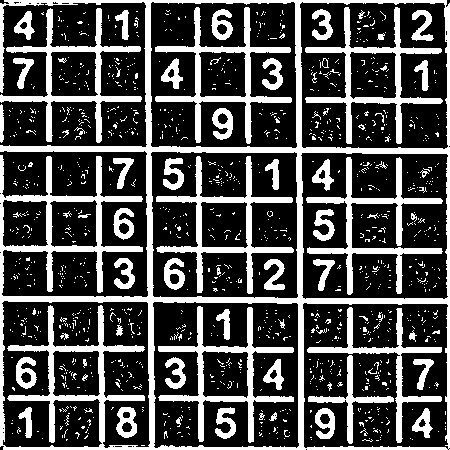

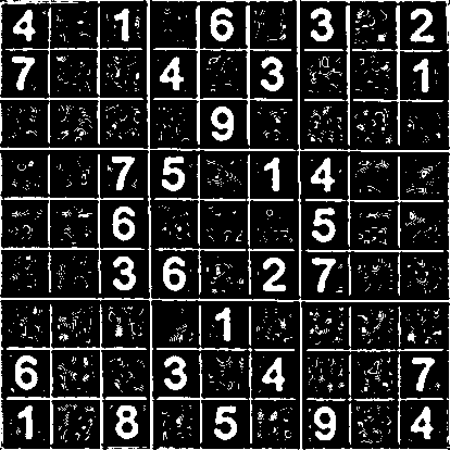

Extracted 81 cells


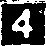

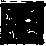

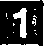

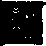

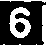

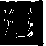

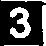

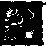

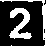

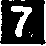

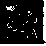

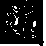

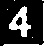

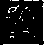

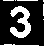

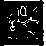

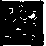

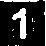

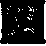

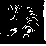

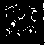

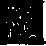

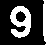

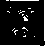

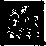

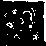

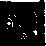

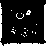

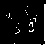

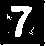

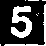

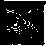

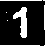

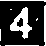

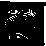

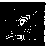

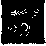

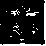

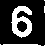

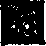

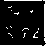

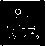

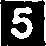

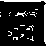

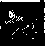

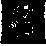

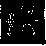

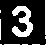

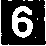

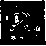

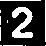

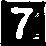

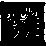

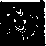

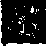

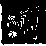

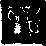

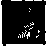

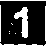

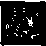

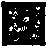

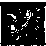

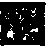

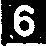

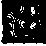

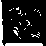

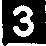

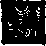

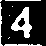

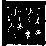

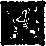

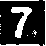

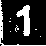

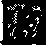

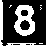

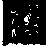

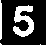

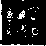

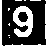

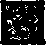

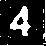

In [ ]:
# Suppose `warped` is your top-down Sudoku image
thresh, steps = preprocess_wrapped_sudoku(warped_image, show_steps=True)

# Now split 'thresh' into 81 cells
cells = split_into_cells(thresh,visualize=True)
print(f"Extracted {len(cells)} cells")

# Example: visualize one cell
for cell in cells:
  cv2_imshow(cell)

In [ ]:
def detect_digit_debug(cell, idx=None):
    if len(cell.shape) == 3:
        cell = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print(f"[{idx}] No contours")
        return False

    h, w = thresh.shape
    detected = False

    for c in contours:
        x, y, cw, ch = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        aspect_ratio = cw / ch if ch > 0 else 0
        fill_ratio = area / (cw * ch)
        cx, cy = x + cw // 2, y + ch // 2

        print(f"[{idx}] area={area:.1f}, ar={aspect_ratio:.2f}, fill={fill_ratio:.2f}, pos=({cx},{cy})")

        # visualize
        vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        cv2.rectangle(vis, (x, y), (x + cw, y + ch), (0, 255, 0), 1)
        cv2_imshow(vis)
        cv2.waitKey(0)

    return detected


[None] area=1709.0, ar=1.00, fill=0.84, pos=(23,23)


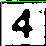

[None] area=0.0, ar=2.00, fill=0.00, pos=(36,1)


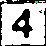

[None] area=0.0, ar=2.00, fill=0.00, pos=(28,1)


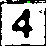

[None] area=0.0, ar=1.00, fill=0.00, pos=(18,0)


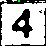

[None] area=1.0, ar=2.50, fill=0.10, pos=(14,1)


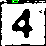

[None] area=3.5, ar=3.50, fill=0.25, pos=(3,1)


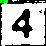

[None] area=1742.5, ar=1.05, fill=0.86, pos=(23,23)


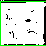

[None] area=0.0, ar=7.00, fill=0.00, pos=(13,1)


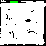

[None] area=1.5, ar=2.50, fill=0.15, pos=(3,1)


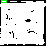

[None] area=1784.5, ar=0.96, fill=0.88, pos=(22,23)


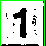

[None] area=1769.0, ar=1.00, fill=0.84, pos=(23,23)


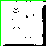

[None] area=1766.0, ar=1.05, fill=0.87, pos=(23,23)


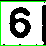

[None] area=1805.5, ar=0.96, fill=0.89, pos=(22,23)


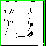

[None] area=1794.0, ar=1.00, fill=0.85, pos=(23,23)


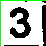

[None] area=1800.0, ar=1.02, fill=0.87, pos=(23,23)


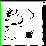

[None] area=0.0, ar=1.00, fill=0.00, pos=(44,38)


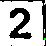

[None] area=0.0, ar=0.25, fill=0.00, pos=(44,31)


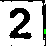

[None] area=1838.5, ar=1.00, fill=0.91, pos=(22,23)


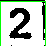

[None] area=1.0, ar=0.40, fill=0.10, pos=(45,2)


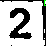

[None] area=1792.0, ar=1.02, fill=0.87, pos=(23,22)


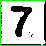

[None] area=1823.0, ar=1.05, fill=0.90, pos=(23,22)


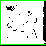

[None] area=1813.0, ar=0.96, fill=0.90, pos=(22,23)


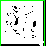

[None] area=1817.0, ar=0.96, fill=0.90, pos=(22,23)


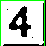

[None] area=1792.5, ar=0.98, fill=0.91, pos=(22,22)


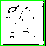

[None] area=1839.0, ar=0.96, fill=0.91, pos=(22,23)


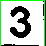

[None] area=1828.5, ar=0.96, fill=0.90, pos=(22,23)


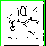

[None] area=1831.5, ar=0.96, fill=0.90, pos=(22,23)


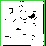

[None] area=1902.0, ar=0.98, fill=0.92, pos=(22,23)


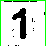

[None] area=1800.5, ar=1.05, fill=0.89, pos=(23,22)


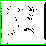

[None] area=1847.0, ar=1.05, fill=0.91, pos=(23,22)


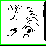

[None] area=1844.5, ar=1.00, fill=0.91, pos=(22,22)


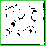

[None] area=1844.0, ar=1.02, fill=0.89, pos=(23,22)


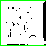

[None] area=1865.0, ar=1.02, fill=0.90, pos=(23,22)


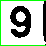

[None] area=1867.5, ar=0.98, fill=0.90, pos=(22,23)


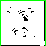

[None] area=1868.5, ar=1.00, fill=0.88, pos=(23,23)


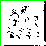

[None] area=1885.5, ar=1.00, fill=0.89, pos=(23,23)


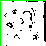

[None] area=1906.0, ar=1.00, fill=0.90, pos=(23,23)


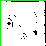

[None] area=1769.5, ar=1.00, fill=0.84, pos=(23,23)


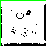

[None] area=1859.0, ar=1.02, fill=0.90, pos=(23,22)


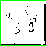

[None] area=1861.5, ar=0.98, fill=0.90, pos=(22,23)


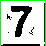

[None] area=1853.5, ar=1.00, fill=0.88, pos=(23,23)


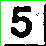

[None] area=1855.5, ar=1.00, fill=0.88, pos=(23,23)


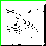

[None] area=1872.0, ar=0.98, fill=0.90, pos=(22,23)


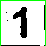

[None] area=1855.0, ar=1.02, fill=0.90, pos=(23,23)


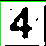

[None] area=1867.0, ar=1.02, fill=0.90, pos=(23,23)


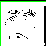

[None] area=1875.0, ar=1.05, fill=0.93, pos=(23,24)


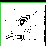

[None] area=1777.5, ar=1.00, fill=0.88, pos=(23,22)


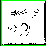

[None] area=1851.5, ar=1.00, fill=0.91, pos=(22,22)


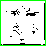

[None] area=1896.0, ar=0.98, fill=0.92, pos=(22,23)


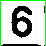

[None] area=1843.5, ar=1.00, fill=0.87, pos=(23,23)


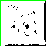

[None] area=1863.5, ar=1.00, fill=0.88, pos=(23,23)


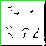

[None] area=1903.5, ar=0.98, fill=0.92, pos=(22,23)


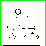

[None] area=1859.0, ar=1.00, fill=0.88, pos=(23,23)


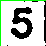

[None] area=1861.0, ar=1.02, fill=0.90, pos=(23,23)


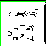

[None] area=1879.0, ar=0.98, fill=0.91, pos=(22,23)


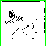

[None] area=1826.0, ar=1.05, fill=0.90, pos=(23,22)


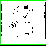

[None] area=1865.5, ar=1.02, fill=0.90, pos=(23,22)


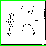

[None] area=1886.5, ar=1.02, fill=0.91, pos=(23,22)


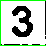

[None] area=1873.0, ar=1.00, fill=0.92, pos=(23,22)


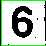

[None] area=1869.5, ar=1.02, fill=0.90, pos=(23,22)


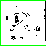

[None] area=1894.0, ar=1.00, fill=0.90, pos=(23,23)


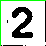

[None] area=1859.5, ar=1.00, fill=0.88, pos=(23,23)


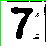

[None] area=1849.5, ar=1.02, fill=0.89, pos=(23,23)


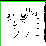

[None] area=1886.5, ar=1.00, fill=0.89, pos=(23,23)


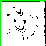

[None] area=1859.5, ar=1.00, fill=0.88, pos=(23,23)


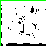

[None] area=1864.0, ar=1.02, fill=0.90, pos=(23,22)


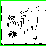

[None] area=1863.0, ar=1.00, fill=0.88, pos=(23,23)


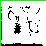

[None] area=1797.5, ar=0.98, fill=0.87, pos=(23,23)


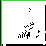

[None] area=1838.5, ar=1.02, fill=0.89, pos=(23,23)


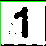

[None] area=1889.5, ar=1.02, fill=0.91, pos=(23,23)


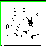

[None] area=1790.0, ar=1.00, fill=0.88, pos=(23,23)


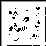

[None] area=1833.0, ar=1.05, fill=0.91, pos=(23,24)


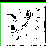

[None] area=1843.5, ar=1.05, fill=0.91, pos=(23,24)


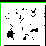

[None] area=1849.5, ar=0.98, fill=0.89, pos=(23,23)


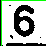

[None] area=1811.5, ar=1.02, fill=0.91, pos=(23,22)


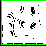

[None] area=1803.5, ar=0.98, fill=0.87, pos=(23,23)


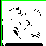

[None] area=1806.5, ar=0.96, fill=0.89, pos=(24,23)


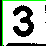

[None] area=1831.5, ar=1.00, fill=0.87, pos=(23,23)


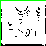

[None] area=1866.5, ar=1.00, fill=0.88, pos=(23,23)


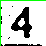

[None] area=1811.5, ar=0.96, fill=0.90, pos=(24,23)


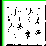

[None] area=1814.0, ar=1.00, fill=0.86, pos=(23,23)


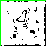

[None] area=1860.0, ar=0.98, fill=0.90, pos=(22,23)


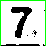

[None] area=0.5, ar=1.00, fill=0.12, pos=(1,45)


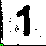

[None] area=0.0, ar=1.00, fill=0.00, pos=(1,30)


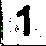

[None] area=0.0, ar=1.00, fill=0.00, pos=(1,26)


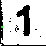

[None] area=1872.0, ar=1.00, fill=0.92, pos=(23,22)


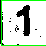

[None] area=1858.5, ar=1.02, fill=0.90, pos=(23,22)


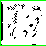

[None] area=0.0, ar=1.00, fill=0.00, pos=(31,44)


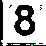

[None] area=0.0, ar=4.00, fill=0.00, pos=(28,44)


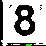

[None] area=0.0, ar=7.00, fill=0.00, pos=(16,44)


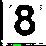

[None] area=0.0, ar=1.00, fill=0.00, pos=(11,44)


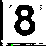

[None] area=1799.5, ar=0.98, fill=0.87, pos=(23,23)


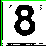

[None] area=1822.0, ar=0.96, fill=0.90, pos=(24,23)


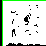

[None] area=1901.5, ar=1.02, fill=0.92, pos=(23,22)


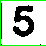

[None] area=1897.5, ar=1.00, fill=0.90, pos=(23,23)


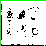

[None] area=1833.5, ar=0.96, fill=0.91, pos=(24,23)


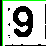

[None] area=1831.5, ar=1.02, fill=0.88, pos=(23,22)


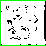

[None] area=1920.5, ar=1.00, fill=0.91, pos=(23,23)


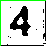

In [ ]:
for cell in cells:
  detect_digit_debug(cell)




